In [1]:
# importing libraries
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import keras
import cv2
%matplotlib inline
#import K-Means
from sklearn.cluster import KMeans
# important metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
data = np.load('cropped_imgs_fetal_regions.npy')
data.shape

(180, 224, 224, 3)

In [3]:
reshaped_array = np.reshape(data, (180, 224, 224, 3))

# Resize each image to 32x32
resized_images = np.empty((180, 32, 32, 3))
for i in range(180):
    resized_images[i] = cv2.resize(reshaped_array[i], (32, 32), interpolation=cv2.INTER_AREA)

In [4]:
resized_images.shape

(180, 32, 32, 3)

In [5]:
with open("manual_annot_CRL_Sagittal.txt", "r") as file:
    # Read the contents of the file
    file_contents = file.read()
lines = file_contents.split('\n')
index = [int(i.split(' ')[0]) for i in lines]
labels = [' '.join(i.split(' ')[1:]) for i in lines]
manual_labels_df = pd.DataFrame()
manual_labels_df['Image ID'] = index
manual_labels_df['label'] = labels

manual_labels_df['label'] = manual_labels_df['label'].apply(lambda x: x.strip())

manual_labels_df = manual_labels_df[manual_labels_df['label'] != 'remove']

num_labels = {'head': 0, 'neck': 1, 'body': 2}

manual_labels_df['encoded_label'] = manual_labels_df['label'].map(num_labels)

y = np.array(manual_labels_df['encoded_label'])

In [6]:
resized_images = resized_images/255.0
reshaped_data = resized_images.reshape(len(resized_images),-1)
reshaped_data.shape

(180, 3072)

In [7]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(3, 3072)

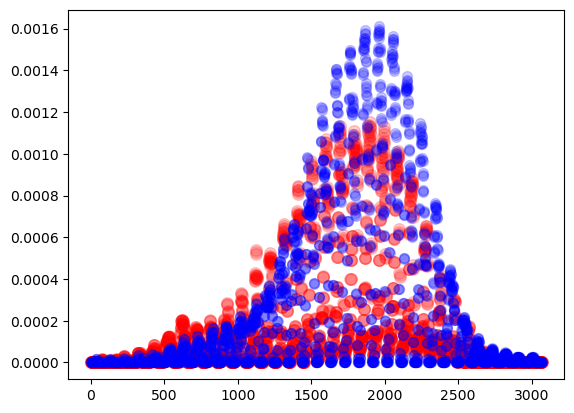

In [8]:
x_data = [i for i in range(3072)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2,s=70)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2,s=50)

In [9]:
# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label
# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = y[clusters[i]]
    return temp_labels

In [10]:
reference_labels = get_reference_dict(clusters,y)
predicted_labels = get_labels(clusters,reference_labels)
print(accuracy_score(predicted_labels,y))

0.22777777777777777


In [11]:
print("Adjusted rand-score: ", adjusted_rand_score(predicted_labels, y))

Adjusted rand-score:  0.02293028781381688


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: 

Accuracy for k = 2:  0.3
Accuracy for k = 16:  0.26666666666666666
Accuracy for k = 64:  0.34444444444444444
Accuracy for k = 100:  0.3611111111111111


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Accuracy for k = 180:  0.34444444444444444


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:1351: ConvergenceWarning: Number of distinct clusters (178) found smaller than n_clusters (180). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


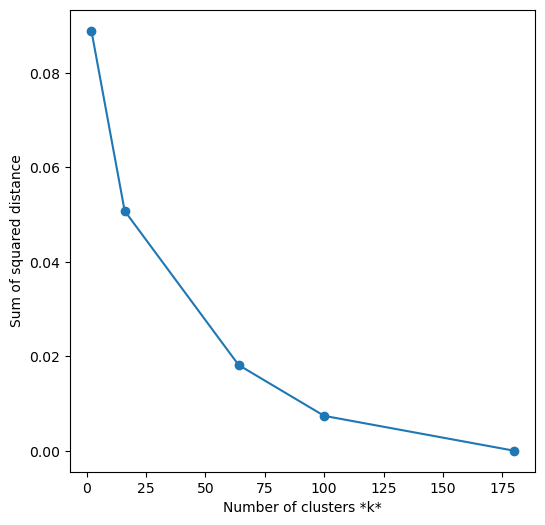

In [12]:
sse = []
list_k = [2,16,64,100,180]
for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters, y)
    predicted_labels = get_labels(clusters,reference_labels)
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels, y))
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

### Notes
1. 256 clusters give 69% accuracy because this method involves no feature extraction
2. There are 2 clusters (cat and dog) but this method of clustering does not suit so well because some dogs might look more like cats and vice-versa

## Using transfer learning 

In [13]:
from keras.applications.resnet import preprocess_input
import keras.utils as image
import keras

In [14]:
IMG_SIZE = 32
model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))

In [15]:
def extract_vector(data_holder):

    resnet_feature_list = []

    for im in data_holder:

        im = image.img_to_array(im) 

        img = preprocess_input(np.expand_dims(im.copy(), axis=0))

        resnet_feature = model.predict(img)

        resnet_feature_np = np.array(resnet_feature)

        resnet_feature_list.append(resnet_feature_np.flatten())
    return np.array(resnet_feature_list)

In [16]:
array = extract_vector(resized_images)
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(array)

1/1 [==============================] - 0s 27ms/step


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [17]:
reference_labels = get_reference_dict(clusters, y)
predicted_labels = get_labels(clusters,reference_labels)

In [18]:

from sklearn.metrics import accuracy_score
print(accuracy_score(predicted_labels, y))

0.28888888888888886


In [19]:
print("Adjusted rand-score: ", adjusted_rand_score(predicted_labels, y))

Adjusted rand-score:  -0.012317698482908476


Text(0.5, 23.52222222222222, 'predicted label')

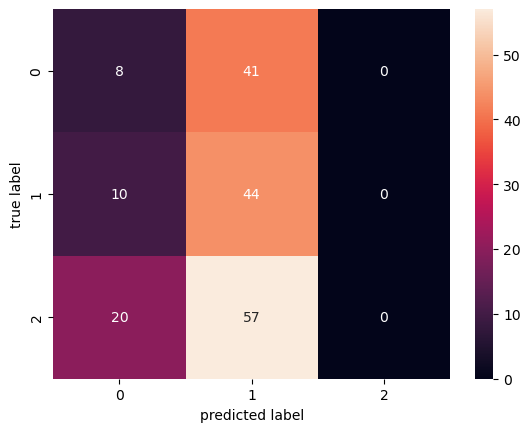

In [20]:
mat = confusion_matrix(y, predicted_labels )
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')